In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from func_statsbomb import get_statsbomb
from func_data_api import getDataAPI

plt.style.use('fivethirtyeight')

palette ={"A": "C1", "B": "C0"}
hue_order = ['A', 'B']

# Data Cleaning and Processing

In the Zone column, the goal was divided into 9 different sections looking at it from the front:

1. Upper left corner
2. Upper center
3. Upper right corner
4. Middle left area
5. Middle center area
6. Middle right area
7. Bottom left corner
8. Bottom center zone
9. Bottom right corner

`Elimination` is the equivalent to crunchtime (potentially terminating penalty)

In [2]:
"""Handy Functions for all data processing"""

def a_b(in_sdf):
    """
    In: Subdataframe with only a game.
    Out: Subdataframe with a column with team A or team B
    """
    sdf = in_sdf.copy()
    a_team = sdf.sort_values(by='Penalty_Number')['Team_name'].values[0]
    sdf['Team'] = ""
    a = ['A' for i in range(len(sdf[sdf['Team_name'].str.contains(a_team)]))]
    b = ['B' for i in range(len(sdf[~sdf['Team_name'].str.contains(a_team)]))]
    sdf.loc[sdf['Team_name'].str.contains(a_team), 'Team'] = a
    sdf.loc[~sdf['Team_name'].str.contains(a_team), 'Team'] = b
    return sdf

def new_coords(num):
    """
    In: number 1-9 with the direction of the goal
    Out: Transformed coordinates to (X,Y) for a plot later
    """
    if num == 1:
        return (1,3)
    elif num == 2:
        return (2,3)
    elif num == 3:
        return (3,3)
    elif num == 4:
        return (1,2)
    elif num == 5:
        return (2,2)
    elif num == 6:
        return (3,2)
    elif num == 7:
        return (1,1)
    elif num == 8:
        return (2,1)
    elif num == 9:
        return (3,1)
    elif num == 0:
        return (0,0)

def make_after_miss(sdf):
    """
    In: Subdataframe of a game.
    Out: Copy of the subdataframe with an appended column with 1 in the row of a penalty that was scored 
        after a miss from the other team and 0 otherwise
    """
    df = sdf.copy()
    df['Make_after_miss'] = [0]*len(df)
    df['after_miss'] = [0]*len(df)
    for i in range(2, sdf['Penalty_Number'].max()+1):
        if (sdf.loc[sdf['Penalty_Number'] == i-1, 'Goal'].values == 0):
            df.iloc[i-1, df.shape[1]-1] = 1
        if (sdf.loc[sdf['Penalty_Number'] == i-1, 'Goal'].values == 0) & (sdf.loc[sdf['Penalty_Number'] == i, 'Goal'].values == 1):
            df.iloc[i-1, df.shape[1]-2] = 1
    return df

def miss_after_make(sdf):
    """
    In: Subdataframe of a game.
    Out: Copy of the subdataframe with an appended column with 1 in the row of a penalty that was missed 
        after a goal from the other team and 0 otherwise
    """
    df = sdf.copy()
    df['Miss_after_make'] = [0]*len(df)
    df['after_make'] = [0]*len(df)
    for i in range(2, sdf['Penalty_Number'].max()+1):
        if (sdf.loc[sdf['Penalty_Number'] == i-1, 'Goal'].values == 1):
            df.iloc[i-1, df.shape[1]-1] = 1
        if (sdf.loc[sdf['Penalty_Number'] == i-1, 'Goal'].values == 1) & (sdf.loc[sdf['Penalty_Number'] == i, 'Goal'].values == 0):
            df.iloc[i-1, df.shape[1]-2] = 1
    return df

def home_team_played(sdf):
    """
    In: Subdataframe of a game.
    Out: Copy of the subdataframe with an appended column of all 1's if the home team played
    """
    df = sdf.copy()
    df['Home_team_played'] = [0]*len(df)
    if sdf['Home'].max() == 1:
        df['Home_team_played'] = [1]*len(df)
    return df

def keeper_changed_game(sdf):
    """
    In: Subdataframe of a game.
    Out: Copy of the subdataframe with an appended column of all 1's if one of the goalkeepers had been
     substituted in that game
    """
    df = sdf.copy()
    df['Keeper_changed_game'] = [0]*len(df)
    if sdf['Keeper_changed'].max() == 1:
        df['Keeper_changed_game'] = [1]*len(df)
    return df

def transformations(in_df):
    """
    In: First dataframe with preprocessed data.
    Out: Dataframe with columns appended from previous methods
    """
    df = in_df.copy()

    # Add column to know the penalty number if it was missed
    df['Missed_Number'] = np.zeros(df.shape[0]).astype(int)
    df.loc[df['Goal'] == 0, 'Missed_Number'] = df.loc[df['Goal'] == 0, 'Penalty_Number']

    # Add column to filter the round of each penalty
    df['Round'] = np.ceil(df['Penalty_Number']/2).astype(int)

    df[['new_coords_x', 'new_coords_y']] = df['Zone'].apply(new_coords).apply(pd.Series)

    # Column of ones for shots later
    df['shot'] = np.ones(len(df))

    # Apply rest of transformations
    df = df.groupby('Game_id').apply(make_after_miss).reset_index(drop=True)
    df = df.groupby('Game_id').apply(miss_after_make).reset_index(drop=True)
    df = df.groupby('Game_id').apply(home_team_played).reset_index(drop=True)
    df = df.groupby('Game_id').apply(a_b).reset_index(drop = True)
    df = df.groupby('Game_id').apply(keeper_changed_game).reset_index(drop = True)
    
    return df


In [3]:
# Read world_cup data from excel
wc = pd.read_excel('../data/wc_data.xlsx')
wc.dropna(axis = 0, inplace=True)

# Get data from statsbomb
stats_bombs = get_statsbomb()

# Get data from API-football
data_api = getDataAPI()

# Concatenate the three and reindex
games = pd.concat([wc, stats_bombs, data_api], axis=0)
games.index = range(len(games))

# Add column to rename the column team
games.rename({'Team': 'Team_name'}, axis=1, inplace=True)
games

,Game_id,Team_name,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination,Home,Keeper_changed
0,1,FRA,7,R,R,1.0,1.0,1,0,0.0,0.0
1,1,GER,9,R,C,1.0,1.0,2,0,0.0,0.0
2,1,FRA,6,R,L,1.0,1.0,3,0,0.0,0.0
3,1,GER,2,R,C,1.0,1.0,4,0,0.0,0.0
4,1,FRA,9,R,L,1.0,1.0,5,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2722,arab_cup2021_817314,Qatar,0,0,0,1.0,1.0,8,1,0.0,0.0
2723,arab_cup2021_817314,Egypt,0,0,0,1.0,1.0,9,0,0.0,0.0
2724,arab_cup2021_817314,Qatar,0,0,0,1.0,1.0,10,1,0.0,0.0
2725,arab_cup2021_817314,Egypt,0,0,0,1.0,1.0,11,0,0.0,0.0


In [4]:
games = transformations(games)
games

,Game_id,Team_name,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination,Home,...,new_coords_x,new_coords_y,shot,Make_after_miss,after_miss,Miss_after_make,after_make,Home_team_played,Team,Keeper_changed_game
0,1,FRA,7,R,R,1.0,1.0,1,0,0.0,...,1,1,1.0,0,0,0,0,0,A,0
1,1,GER,9,R,C,1.0,1.0,2,0,0.0,...,3,1,1.0,0,0,0,1,0,B,0
2,1,FRA,6,R,L,1.0,1.0,3,0,0.0,...,3,2,1.0,0,0,0,1,0,A,0
3,1,GER,2,R,C,1.0,1.0,4,0,0.0,...,2,3,1.0,0,0,0,1,0,B,0
4,1,FRA,9,R,L,1.0,1.0,5,0,0.0,...,3,1,1.0,0,0,0,1,0,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,wc_u202019_330559,Senegal U20,0,0,0,1.0,1.0,6,0,0.0,...,0,0,1.0,0,0,0,1,0,B,0
2723,wc_u202019_330559,Korea Republic U20,0,0,0,1.0,1.0,7,0,0.0,...,0,0,1.0,0,0,0,1,0,A,0
2724,wc_u202019_330559,Senegal U20,0,0,0,0.0,0.0,8,0,0.0,...,0,0,1.0,0,0,1,1,0,B,0
2725,wc_u202019_330559,Korea Republic U20,0,0,0,1.0,1.0,9,0,0.0,...,0,0,1.0,1,1,0,0,0,A,0


# Studying the per game

In [5]:
# To address questions and graphs that occur per game 
by_game = (
    games.groupby(['Game_id', 'Team'])
    .agg(
        Result = pd.NamedAgg(column = 'Goal', aggfunc =  'sum'), # Get the result
        Penalty_Number = pd.NamedAgg(column = 'Penalty_Number', aggfunc = lambda x: int(np.ceil(x.max()/2))), # Number of pens taken per team
        First_Miss = pd.NamedAgg(column = 'Missed_Number', aggfunc = lambda x: x[x != 0].min()), # When was the first miss
        Home = pd.NamedAgg(column = 'Home', aggfunc = 'max'), # Whether the team was home or not
        Home_played = pd.NamedAgg(column = "Home_team_played", aggfunc='max'), # Whether the home team played in the game
        Keeper_changed = pd.NamedAgg(column = "Keeper_changed", aggfunc='max'), # Whether the keeper was subbed for that team
        Keeper_changed_game = pd.NamedAgg(column = "Keeper_changed_game", aggfunc='max') # Whether the keeper was subbed in the game
    )
)
by_game['Result'] = by_game['Result'].astype(int)
by_game['First_Miss_Round'] = np.ceil(by_game['First_Miss']/2) # Which round was the first miss
by_game[['First_Miss', 'First_Miss_Round']] = by_game[['First_Miss', 'First_Miss_Round']].fillna(0).astype(int) # Correcting for NaN's
by_game

Result  Penalty_Number  First_Miss  Home  Home_played  \
Game_id           Team                                                          
1                 A          4               6           7   0.0            0   
                  B          5               6           6   0.0            0   
2                 A          3               5           1   0.0            0   
                  B          4               5           8   0.0            0   
3                 A          4               4           0   0.0            1   
...                        ...             ...         ...   ...          ...   
wc_u202019_330549 B          5               7          12   0.0            0   
wc_u202019_330555 A          5               5           0   0.0            0   
                  B          4               5           8   0.0            0   
wc_u202019_330559 A          3               5           1   0.0            0   
                  B          2               5           4   0.0            0   

                        Keeper_changed  Keeper_changed_game  First_Miss_Round  
Game_id           Team                                                         
1                 A                0.0                    0                 4  
                  B                0.0                    0                 3  
2                 A                0.0                    0                 1  
                  B                0.0                    0                 4  
3                 A                0.0                    0                 0  
...                                ...                  ...               ...  
wc_u202019_330549 B                0.0                    0                 6  
wc_u202019_330555 A                0.0                    0                 0  
                  B                0.0                    0                 4  
wc_u202019_330559 A                0.0                    0                 1  
                  B                0.0                    0                 2  

[524 rows x 8 columns]

In [6]:
def appendExtras(df):
    """
    In: Dataframe grouped by game and team
    Out: Copy of dataframe with a column appended, casting the type of the home/away team
        and whether the team missed first or second or didn't miss"""
    df_c = df.copy()

    # Win column
    df_c.loc[:,'Win'] = np.zeros(df.shape[0])
    df_c.loc[df['Result'] == df['Result'].max(), 'Win'] = 1

    # Home cast
    df_c['Home'] = df_c['Home'].map({1: 'Home', 0: 'Away'})

    # Missed first
    df_c['missed_first'] = np.zeros(df.shape[0])
    if df_c.loc[(slice(None),'A'), 'First_Miss'].values <= df_c.loc[(slice(None),'B'), 'First_Miss'].values:
        if df_c.loc[(slice(None),'A'), 'First_Miss'].values != 0:
            df_c['missed_first'] = ['First Miss', 'Second Miss']
        else: 
            df_c['missed_first'] = ['No Miss', 'First Miss']
    else:
        if df_c.loc[(slice(None),'B'), 'First_Miss'].values != 0:
            df_c['missed_first'] = ['Second Miss', 'First Miss']
        else: 
            df_c['missed_first'] = ['First Miss', 'No Miss']
    return df_c

by_game = by_game.groupby('Game_id').apply(appendExtras)
by_game['First_Miss_Round'] = by_game['First_Miss_Round'].astype('category') # Convert to categorical variable
by_game.head()


Result  Penalty_Number  First_Miss  Home  Home_played  \
Game_id Team                                                          
1       A          4               6           7  Away            0   
        B          5               6           6  Away            0   
2       A          3               5           1  Away            0   
        B          4               5           8  Away            0   
3       A          4               4           0  Away            1   

              Keeper_changed  Keeper_changed_game First_Miss_Round  Win  \
Game_id Team                                                              
1       A                0.0                    0                4  0.0   
        B                0.0                    0                3  1.0   
2       A                0.0                    0                1  0.0   
        B                0.0                    0                4  1.0   
3       A                0.0                    0                0  1.0   

             missed_first  
Game_id Team               
1       A     Second Miss  
        B      First Miss  
2       A      First Miss  
        B     Second Miss  
3       A         No Miss

No handles with labels found to put in legend.


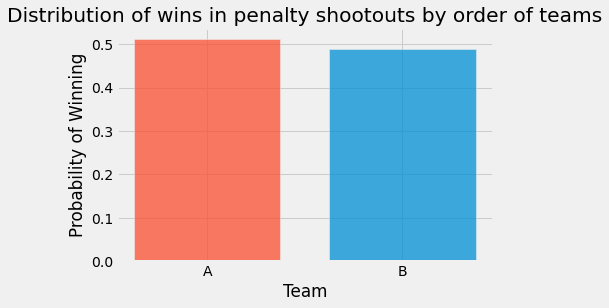

In [7]:
sns.histplot(x = by_game[by_game['Win'] == 1].sort_index(level = 1, ascending = True).index.get_level_values(1), 
hue = by_game.loc[(by_game['Win'] == 1)].sort_index(level = 1, ascending = True).index.get_level_values(1),
stat = 'density', alpha=.75, palette=palette, shrink = .75)
plt.title('Distribution of wins in penalty shootouts by order of teams')
plt.ylabel('Probability of Winning')
plt.xlabel('Team')
plt.legend().remove()
# plt.savefig('../images/ps_order_teams2.png', bbox_inches="tight")

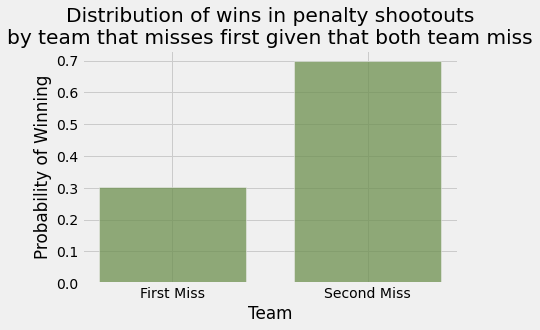

In [8]:
sns.histplot(x = by_game.loc[(by_game['Win'] == 1) & (by_game['First_Miss']!= 0), 'missed_first'],
stat = 'density', alpha=.75, color='C3', shrink = .75)
plt.title('Distribution of wins in penalty shootouts\nby team that misses first given that both team miss')
plt.ylabel('Probability of Winning')
plt.xlabel('Team')
plt.show()
# plt.savefig('../images/ps_both_miss.png', bbox_inches="tight")

In [9]:
1-by_game['First_Miss'].value_counts()[0]/len(by_game.index.get_level_values(0).unique())

0.5190839694656488

In [10]:
pd.pivot_table(by_game[by_game['First_Miss'] != 0], index = 'Team', columns = 'missed_first', values = 'Win', aggfunc= lambda x: sum(x == 1))/pd.pivot_table(by_game[by_game['First_Miss'] != 0], index = 'Team', columns = 'missed_first', values = 'Win', aggfunc= len)

missed_first,First Miss,Second Miss
Team,,
A,0.204082,0.770833
B,0.095652,0.659091


In [11]:
pd.pivot_table(by_game[by_game['Home_played'] == 1], index = 'Team', columns = 'Home', values = 'Win', aggfunc= lambda x: sum(x==1))/pd.pivot_table(by_game[by_game['Home_played'] == 1], index = 'Team', columns = 'Home', values = 'Win', aggfunc= 'count')

Home,Away,Home
Team,,
A,0.482759,0.529412
B,0.470588,0.517241


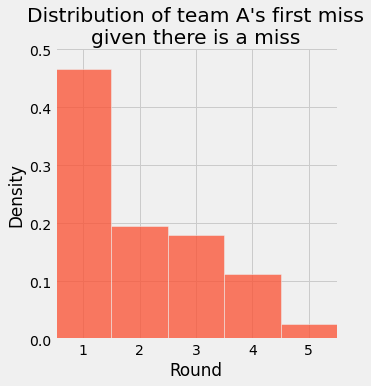

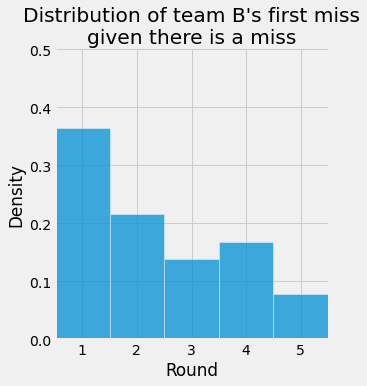

In [12]:
# Distribution for A
sns.displot(x = by_game.loc[(by_game['First_Miss_Round'].index.get_level_values(1) == 'A') & (by_game['First_Miss_Round'] != 0), 'First_Miss_Round'].astype('category'),
color = 'C1', stat = 'density')
plt.title('Distribution of team A\'s first miss\ngiven there is a miss')
plt.xlabel('Round')
plt.xlim((.5,5.5))
plt.ylim((0,.5))
# plt.savefig('../images/ps_prob_a_miss.png', bbox_inches="tight")
# Distribution for B
sns.displot(x = by_game.loc[(by_game['First_Miss_Round'].index.get_level_values(1) == 'B') & (by_game['First_Miss_Round'] != 0), 'First_Miss_Round'].astype('category'),
color = 'C0', stat = 'density')
plt.title('Distribution of team B\'s first miss\ngiven there is a miss')
plt.xlabel('Round')
plt.xlim((.5,5.5))
plt.ylim((0,.5))
# plt.savefig('../images/ps_prob_b_miss.png', bbox_inches="tight")
plt.show()

Text(0.5, 11.11999999999999, 'Round')

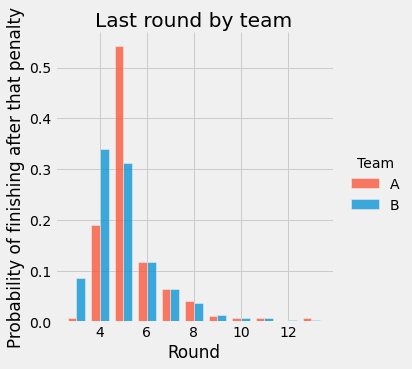

In [13]:
sns.displot(hue = by_game.index.get_level_values(1),
            x = by_game.loc[:, 'Penalty_Number'].astype('category'),
            palette = palette, hue_order = hue_order, stat='density', multiple='dodge', shrink = .75, common_norm=False)
plt.title('Last round by team')
plt.ylabel('Probability of finishing after that penalty')
plt.xlabel('Round')
# plt.savefig('../images/ps_last_shot.png', bbox_inches="tight")

# Per penalty round

In [14]:
# To study regardless what happened each round for team A and team B
by_round = (
    games.groupby(['Team', 'Round'])
    .agg(Num_shots = pd.NamedAgg(column = 'Round', aggfunc = 'count'), # Number of penalty taken in that round
         Num_goals = pd.NamedAgg(column = 'Goal', aggfunc = 'sum'), # Number of goals in that round
         Num_miss_after_make = pd.NamedAgg(column = 'Miss_after_make', aggfunc = 'sum'), # Number of missed penalties after the other team scored
         Num_make_after_miss = pd.NamedAgg(column = 'Make_after_miss', aggfunc = 'sum'), # Number of made penalties after the other team missed
         Num_after_make = pd.NamedAgg(column = 'after_make', aggfunc = 'sum'), # Total number of penalties taken after the other team scored
         Num_after_miss = pd.NamedAgg(column = 'after_miss', aggfunc = 'sum') # Total number of penalties taken after the other team missed
    )
)

# Following probabilities of each round according to Laplace's rule
by_round['prob_make'] = by_round['Num_goals']/by_round['Num_shots']
by_round['prob_miss_after_make'] = by_round['Num_miss_after_make']/by_round['Num_after_make']
by_round['prob_make_after_miss'] = by_round['Num_make_after_miss']/by_round['Num_after_miss']
by_round

Num_shots  Num_goals  Num_miss_after_make  Num_make_after_miss  \
Team Round                                                                   
A    1            264      172.0                    0                    1   
     2            268      212.0                   39                   60   
     3            274      200.0                   55                   50   
     4            247      182.0                   44                   34   
     5            205      158.0                   31                   47   
     6             67       48.0                   13                   10   
     7             36       33.0                    3                    7   
     8             20       16.0                    2                    0   
     9              9        9.0                    0                    1   
     10             6        6.0                    0                    0   
     11             4        4.0                    0                    0   
     12             2        2.0                    0                    0   
     13             2        1.0                    0                    0   
B    1            260      186.0                   60                   75   
     2            256      195.0                   49                   42   
     3            250      193.0                   42                   46   
     4            252      178.0                   53                   49   
     5            155      111.0                   35                   23   
     6             69       51.0                   13                   13   
     7             38       28.0                    9                    5   
     8             20       18.0                    2                    4   
     9             10       10.0                    0                    0   
     10             6        6.0                    0                    0   
     11             4        4.0                    0                    0   
     12             2        1.0                    1                    0   
     13             1        1.0                    0                    1   

            Num_after_make  Num_after_miss  prob_make  prob_miss_after_make  \
Team Round                                                                    
A    1                   0               2   0.651515                   NaN   
     2                 191              77   0.791045              0.204188   
     3                 205              69   0.729927              0.268293   
     4                 192              55   0.736842              0.229167   
     5                 142              63   0.770732              0.218310   
     6                  51              16   0.716418              0.254902   
     7                  29               7   0.916667              0.103448   
     8                  18               2   0.800000              0.111111   
     9                   8               1   1.000000              0.000000   
     10                  6               0   1.000000              0.000000   
     11                  4               0   1.000000              0.000000   
     12                  2               0   1.000000              0.000000   
     13                  1               1   0.500000              0.000000   
B    1                 171              89   0.715385              0.350877   
     2                 202              54   0.761719              0.242574   
     3                 189              61   0.772000              0.222222   
     4                 182              70   0.706349              0.291209   
     5                 123              32   0.716129              0.284553   
     6                  51              18   0.739130              0.254902   
     7                  32               6   0.736842              0.281250   
     8                  16               4   0.900000              0.125000   
     9    

In [15]:
by_round.groupby('Team')['Num_goals'].sum()/by_round.groupby('Team')['Num_shots'].sum()

Team
A    0.742877
B    0.742252
dtype: float64

In [16]:
by_round['Num_goals'].sum()/by_round['Num_shots'].sum()

0.7425742574257426

([<matplotlib.axis.XTick at 0x1ebc350a700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

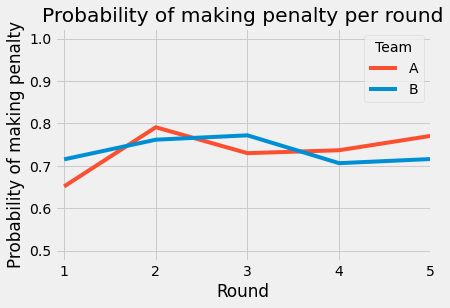

In [17]:
sns.lineplot(x = by_round.index.get_level_values(1), y = by_round['prob_make'], hue = by_round.index.get_level_values(0), palette = palette)
plt.title('Probability of making penalty per round')
plt.ylabel('Probability of making penalty')
plt.xlabel('Round')
plt.xlim((.9,5))
plt.xticks([1,2,3,4,5])
# plt.savefig('../images/ps_prob_scoring.png', bbox_inches="tight")

In [18]:
# by_round[['prob_miss_after_make', 'prob_make_after_miss']].to_csv('../data/miss_after_make_make_after_miss ')

# Location of the shot

In [19]:
games_with_loc = games[games['Zone'] != 0] # Filtering for those penalties that we know the shot location, only from kaggle and statsbomb

In [20]:
by_shot_zone = games_with_loc.pivot_table(columns = 'new_coords_x', index='new_coords_y', values='shot', aggfunc= 'sum').sort_index(ascending=False)/len(games_with_loc)

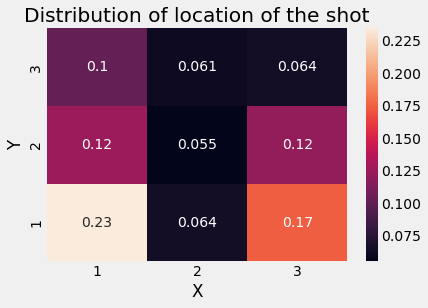

In [21]:
sns.heatmap(data=by_shot_zone, annot=True)
plt.title('Distribution of location of the shot')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
# plt.savefig('../images/ps_by_zone.png', bbox_inches="tight")

In [22]:
by_goal_zone = games_with_loc.pivot_table(columns = 'new_coords_x', index='new_coords_y', values='Goal', aggfunc= 'sum').sort_index(ascending=False)/games_with_loc.pivot_table(columns = 'new_coords_x', index='new_coords_y', values='shot', aggfunc= 'sum').sort_index(ascending=False)

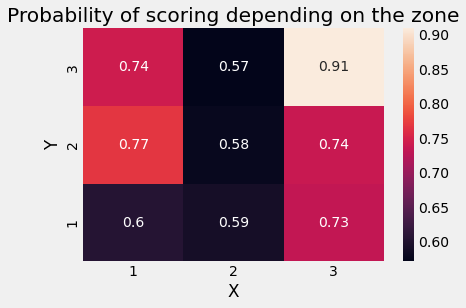

In [23]:
sns.heatmap(data=by_goal_zone, annot=True)
plt.title('Probability of scoring depending on the zone')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
# plt.savefig('../images/ps_zone_goal.png', bbox_inches="tight")

In [24]:
games_with_loc.loc[:,'Natural'] = np.zeros(len(games_with_loc))
games_with_loc.loc[(games_with_loc['Foot'] == 'R') & (games_with_loc['Zone'] != 1) & (games_with_loc['Zone'] != 4) & (games_with_loc['Zone'] != 7), 'Natural'] = 1
games_with_loc.loc[(games_with_loc['Foot'] == 'L') & (games_with_loc['Zone'] != 3) & (games_with_loc['Zone'] != 6) & (games_with_loc['Zone'] != 9), 'Natural'] = 1

C:\Users\Gonzalo\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Gonzalo\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [25]:
games_with_loc.loc[games_with_loc['Natural'] == 1, 'Goal'].sum()/games_with_loc.loc[games_with_loc['Natural'] == 1, 'shot'].sum()

0.6871508379888268

In [26]:
pd.pivot_table(games_with_loc, 
                index = 'Foot',
                columns = 'Natural',
                values = 'Goal',
                aggfunc = 'sum')/pd.pivot_table(games_with_loc, 
                index = 'Foot',
                columns = 'Natural',
                values = 'shot',
                aggfunc = 'sum')

Natural,0.0,1.0
Foot,,
L,0.757576,0.634146
R,0.684211,0.702899


In [27]:
games_with_loc.loc[games_with_loc['Keeper'] != 0, 'Keeper'].value_counts()/len(games_with_loc.loc[games_with_loc['Keeper'] != 0, 'Keeper'])

L    0.462366
R    0.408602
C    0.129032
Name: Keeper, dtype: float64